In [1]:
import numpy as np
from math import atan2, pi
import matplotlib.pyplot as plt
import json

# Opening the polygon file

In [2]:
# path_to_testfile = "./instances_v2/instances/fpg-poly_0000000020_h1.instance.json"
# path_to_testfile = "./instances_v2/instances/socg60.instance.json"
# path_to_testfile = "../instances/fpg-poly_0000000020_h2.instance.json"

path_to_testfile = "./instances_v2/instances/fpg-poly_0000000020_h2.instance.json"

with open(path_to_testfile) as testfile:
    polygon = json.load(testfile)

In [3]:
print(polygon['type'])
print(polygon['name'])
print(polygon['n'])
print(polygon['outer_boundary'])
print(polygon['holes'])
print(len(polygon['holes']))


CGSHOP2023_Instance
fpg-poly_0000000020_h2
29
[{'x': 191850806, 'y': 207276863}, {'x': 233102742, 'y': 118763799}, {'x': 409746058, 'y': 102221492}, {'x': 518170442, 'y': 145990133}, {'x': 658393154, 'y': 84033988}, {'x': 969944537, 'y': 312412941}, {'x': 1073741824, 'y': 27398453}, {'x': 1006306257, 'y': 249250792}, {'x': 972122497, 'y': 406678785}, {'x': 841172557, 'y': 554365113}, {'x': 602711995, 'y': 719961446}, {'x': 498647195, 'y': 529671996}, {'x': 385673579, 'y': 956170210}, {'x': 286048011, 'y': 834661731}, {'x': 119059789, 'y': 817096511}, {'x': 101820302, 'y': 714800549}, {'x': 43085140, 'y': 404568818}, {'x': 18786073, 'y': 316887810}, {'x': 0, 'y': 194728036}, {'x': 142609572, 'y': 0}]
[[{'x': 349623949, 'y': 227499932}, {'x': 359939980, 'y': 768422084}, {'x': 378607327, 'y': 267682836}], [{'x': 68249156, 'y': 418481519}, {'x': 178867385, 'y': 723985109}, {'x': 345167289, 'y': 859001776}, {'x': 278159008, 'y': 298820764}, {'x': 274224193, 'y': 136143764}, {'x': 252289409,

### Plotting the polygon

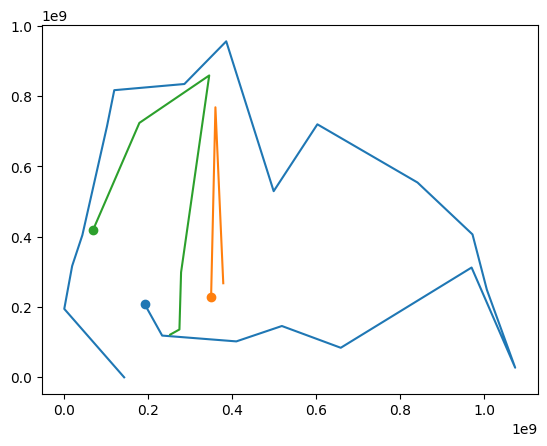

In [4]:
listpolygon = []
for pt in polygon['outer_boundary']:
    listpolygon.append([pt['x'], pt['y']])

listpolygon = np.array(listpolygon)

plt.plot(listpolygon.T[0], listpolygon.T[1])
# plt.scatter(listpolygon.T[0][1:], listpolygon.T[1][1:])
plt.scatter(listpolygon[0][0], listpolygon[0][1])

for hole in polygon['holes']:
    listhole = []
    for pt in hole:
        listhole.append([pt['x'], pt['y']])
    
    listhole = np.array(listhole)

    plt.plot(listhole.T[0], listhole.T[1])
    # plt.scatter(listhole.T[0][1:], listhole.T[1][1:])
    plt.scatter(listhole[0][0], listhole[0][1])

plt.show()


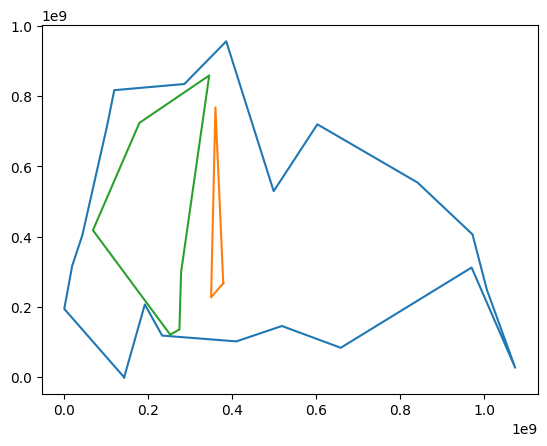

In [5]:
def polygon_plt():
    listpolygon = [[polygon['outer_boundary'][-1]['x'],polygon['outer_boundary'][-1]['y']]]
    for pt in polygon['outer_boundary']:
        listpolygon.append([pt['x'], pt['y']])

    listpolygon = np.array(listpolygon)

    plt.plot(listpolygon.T[0], listpolygon.T[1])

    for hole in polygon['holes']:
        listhole = [[hole[-1]['x'], hole[-1]['y']]]
        for pt in hole:
            listhole.append([pt['x'], pt['y']])
        
        listhole = np.array(listhole)

        plt.plot(listhole.T[0], listhole.T[1])
    
polygon_plt()
plt.show()

# Polygon & helper classes

In [6]:
class Point:
    def __init__(self, x, y, parent, incoming, outgoing):
        self.coordinate = (x,y)
        self.parent = parent
        self.incoming = incoming
        self.outgoing = outgoing

#In case we still want a point class with only 1 list we can use this
class Point1List:
    def __init__(self, x, y, parent, adjacent):
        self.coordinate = (x,y)
        self.parent = parent
        self.adjacent = adjacent
        
class Edge:
    def __init__(self, pt1, pt2, parent):
        self.pt1 = pt1
        self.pt2 = pt2
        self.parent = parent

class Polygon:
    def __init__(self, isHole, points, edges, holes):
        self.isHole = isHole
        self.points = points
        self.edges = edges
        self.holes = holes

    def setholes(self, holes_new):
        self.holes = holes_new


### Turning polygon dictionary from file into Polygon class

In [7]:
#Creating outer boundary pts, edges, polygon
listpts = []
listpolygons = []
listedges = []
alledges = []
#allpoints = []

#Create points + Edges
for pt in polygon['outer_boundary']:
    (x,y) = [pt['x'], pt['y']]
    #p = Point1List(x,y, None, [])
    p = Point(x,y, None, [], [])
    #print(p.coordinate[0], p.coordinate[1])
    listpts.append(p)

counter = 0
for pt in listpts:
    e = Edge(listpts[counter-1], listpts[counter], None)
    listedges.append(e)
    alledges.append(e)
    counter +=1

#Update adjacent edges
z = len(listpts)
for i in range(z):
    #listpts[i].adjacent.append(listedges[i-1])
    listpts[i].incoming.append(listedges[i])
    if i < z-1:
        #listpts[i].adjacent.append(listedges[i+1])
        listpts[i].outgoing.append(listedges[i+1])
    else:
        listpts[i].outgoing.append(listedges[0])
        #listpts[i].adjacent.append(listedges[0])

#allpoints = listpts

#Create polygon and update parent of points/vertices to be this polygon
poly = Polygon(0, listpts, listedges, [])
for edges in poly.edges:
    edges.parent = poly #Update edges parent
for pts in poly.points:
    pts.parent = poly #Update point parent

#Print checks to get items
#for element in poly.points:
#    print(element.coordinate, element.parent, (element.incoming[0].pt1, element.incoming[0].pt2), (element.outgoing[0].pt1, element.outgoing[0].pt2))

print("Basic (Outside) polygon has now", len(poly.edges), "Edges and", len(poly.points), "Points")


Basic (Outside) polygon has now 20 Edges and 20 Points


In [8]:
#Do the same for holes
counter = 0
if len(polygon['holes']) == 0:
    ishole = 0
else:
    ishole = 1

#If we have holes, we are allowed to do this part    
if ishole:

    length_holes = len(polygon['holes'])
    listholepolygons = []
    
    #We might get multiple holes, so 1 list per hole for the edges and points of a hole
    for ctr in range(length_holes):
        listholeedges = []
        listholepts = []
        
        #Points in hole
        length = len(polygon['holes'][ctr])
        for n in range(length):
            (xh,yh) = (polygon['holes'][ctr][n]['x'], polygon['holes'][ctr][n]['y'])
            #print((xh,yh))
            #p = Point1List(xh,yh, None, [])
            p = Point(xh,yh, None, [], [])
            listholepts.append(p)
        
        #Edges in hole
        counter = 0
        for pt in listholepts:
            e = Edge(listholepts[counter-1], listholepts[counter], None)
            #print("EDGE Added:", e.pt1, e.pt2)
            listholeedges.append(e)
            alledges.append(e)
            counter +=1

        #adjacent edges of a point
        z = len(listholepts)
        for i in range(z):
            #listholepts[i].adjacent.append(listholeedges[i])
            listholepts[i].incoming.append(listholeedges[i])
            if i < z-1:
                #listholepts[i].adjacent.append(listholeedges[i+1])
                listholepts[i].outgoing.append(listholeedges[i+1])
            else:
                listholepts[i].outgoing.append(listholeedges[0])
                #listholepts[i].adjacent.append(listedges[0])
              
        counter = 0
        h = Polygon(1, listholepts, listholeedges, [])
        #Update all edges and points to make sure that the parent is set to this hole
        for edges in h.edges:
            edges.parent = h #Update edges parent
        for pts in h.points:
            pts.parent = h #Update point parent
            #allpoints.append(pts)

        #append hole to list
        listholepolygons.append(h)
        
    #add all holes we created in the main polygon
    poly.setholes(listholepolygons)
    #print(len(poly.holes))

    print("Updated (Outside + Holes) polygon has now", len(poly.edges), "Edges and", len(poly.points), "Points, Including", len(poly.holes), "Holes")
    #for element in poly.points:
    #    print(element.coordinate, element.parent, (element.incoming[0].pt1, element.incoming[0].pt2), (element.outgoing[0].pt1, element.outgoing[0].pt2))
    for holex in poly.holes:
        for pt in holex.points:
            print(pt.coordinate)
    #for elem in range(len(alledges)):
    #    print(alledges[elem].pt1, alledges[elem].pt2)

Updated (Outside + Holes) polygon has now 20 Edges and 20 Points, Including 2 Holes
(349623949, 227499932)
(359939980, 768422084)
(378607327, 267682836)
(68249156, 418481519)
(178867385, 723985109)
(345167289, 859001776)
(278159008, 298820764)
(274224193, 136143764)
(252289409, 121547145)


# Useful functions

### Orientation variants

In [9]:
#returns the orientation of p3 wrt line through p1 and p2
def orientation(p1, p2, p3):

    #vector from p1 to p2
    a = [(int(p2['x']) - int(p1['x'])), (int(p2['y']) - int(p1['y']))]
    #vector from p1 to p3
    b = [(int(p3['x']) - int(p1['x'])), (int(p3['y']) - int(p1['y']))]

    #cross product
    cross = int(a[0]) * int(b[1]) - int(a[1]) * int(b[0])

    if cross == 0: #colinear
        return 0
    else: #sign gives left or right of \bar{p1p2}
        return np.sign(cross)

In [10]:
#returns the orientation of p3 wrt line through p1 and p2
def orientation_class(p1, p2, p3):

    #vector from p1 to p2
    a = [(int(p2.coordinate[0]) - int(p1.coordinate[0])), (int(p2.coordinate[1]) - int(p1.coordinate[1]))]
    #vector from p1 to p3
    b = [(int(p3.coordinate[0]) - int(p1.coordinate[0])), (int(p3.coordinate[1]) - int(p1.coordinate[1]))]

    #cross product
    cross = int(a[0]) * int(b[1]) - int(a[1]) * int(b[0])

    if cross == 0: #colinear
        return 0, cross
    else: #sign gives left or right of \bar{p1p2}
        return np.sign(cross), cross

In [11]:
#returns the orientation as sign and its exact value (needed for sorting) of p3 wrt line through p1 and p2 using the coordinates only
def orientation_coordinates(p1, p2, p3):
    #vector from p1 to p2
    a = [(int(p2[0]) - int(p1[0])), (int(p2[1]) - int(p1[1]))]
    #vector from p1 to p3
    b = [(int(p3[0]) - int(p1[0])), (int(p3[1]) - int(p1[1]))]

    #cross product
    cross = int(a[0]) * int(b[1]) - int(a[1]) * int(b[0])
    val = cross

    if cross == 0: #colinear
        return 0, val
    else: #sign gives left or right of \bar{p1p2} and the exact value
        return np.sign(cross), val

### Finding reflex vertices

In [12]:
def find_reflex(polygon):
    n = polygon['n']
    bdry = polygon['outer_boundary']
    holes = polygon['holes']
    count = 0
    reflex = []

    for i in range(len(bdry)):
        if orientation(bdry[(i-1)], bdry[i], bdry[(i+1) % len(bdry)]) == -1: reflex.append(bdry[i]); count += 1

    for hole in holes:
        for i in range(len(hole)):
            if orientation(hole[(i-1)], hole[i], hole[(i+1) % len(hole)]) == -1: reflex.append(hole[i]); count += 1

    return reflex, count

In [13]:
def find_reflex_in_class(polygon):
    bdry = polygon.points
    holes = polygon.holes
    count = 0
    reflex = []

    for i in range(len(bdry)):
        if orientation_class(bdry[(i-1)], bdry[i], bdry[(i+1) % len(bdry)])[0] == -1: 
            reflex.append(bdry[i]); count += 1
    
    print("We found", len(reflex), "Reflex points in our outer boundary of the polygon")
    for hole in holes:
        for i in range(len(hole.points)):
            if orientation_class(hole.points[(i-1)], hole.points[i], hole.points[(i+1) % len(hole.points)])[0] == -1: 
                reflex.append(hole.points[i]); count += 1

    return reflex, count

refl, nr = find_reflex_in_class(poly)
print("We found", nr, "reflex vertices in the polygon (including its holes)")
#for i in refl:
#    print(i.coordinate, i.incoming[0].pt1, i.incoming[0].pt2, i.outgoing[0].pt1, i.outgoing[0].pt2)

We found 8 Reflex points in our outer boundary of the polygon
We found 16 reflex vertices in the polygon (including its holes)


### Plotting reflex vertices 

In [14]:
reflex, r = find_reflex(polygon)

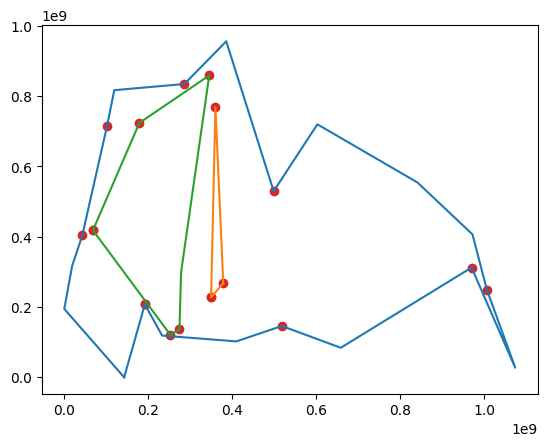

In [15]:
listpolygon = [[polygon['outer_boundary'][-1]['x'], polygon['outer_boundary'][-1]['y']]]
for pt in polygon['outer_boundary']:
    listpolygon.append([pt['x'], pt['y']])

listpolygon = np.array(listpolygon)

plt.plot(listpolygon.T[0], listpolygon.T[1])
# plt.scatter(listpolygon.T[0][1:], listpolygon.T[1][1:])
plt.scatter(listpolygon[1][0], listpolygon[1][1])

for hole in polygon['holes']:
    listhole = [[hole[-1]['x'], hole[-1]['y']]]
    for pt in hole:
        listhole.append([pt['x'], pt['y']])
    
    listhole = np.array(listhole)

    plt.plot(listhole.T[0], listhole.T[1])
    # plt.scatter(listhole.T[0][1:], listhole.T[1][1:])
    plt.scatter(listhole[1][0], listhole[1][1])

listreflex = []
for pt in reflex:
    listreflex.append([pt['x'], pt['y']])

listreflex = np.array(listreflex)

plt.scatter(listreflex.T[0], listreflex.T[1])

plt.show()

### Angle between 3 points

In [16]:
def angle(p1: Point, p2: Point, p3: Point):
    # Ax, Ay = p1.coordinate[0] - p2.coordinate[0], p1.coordinate[1] - p2.coordinate[1]
    # Cx, Cy = p3.coordinate[0] - p2.coordinate[0], p3.coordinate[1] - p2.coordinate[1]
    Ax, Ay = p3.coordinate[0] - p2.coordinate[0], p3.coordinate[1] - p2.coordinate[1]
    Cx, Cy = p1.coordinate[0] - p2.coordinate[0], p1.coordinate[1] - p2.coordinate[1]

    a = atan2(Ay, Ax)
    c = atan2(Cy, Cx)
    if a < 0: a += pi*2
    if c < 0: c += pi*2
    return (pi*2 + c - a) if a > c else (c - a) 

### Misc

In [17]:
def dist(p: Point, q: Point):
    return np.sqrt((p.coordinate[0] - q.coordinate[0])**2 + (p.coordinate[1] - q.coordinate[1])**2)

In [18]:
def intersection_point(l1: Edge, l2: Edge):
    # get the slopes from the lines defined by the endpoints of the edge
    slope1 = (l1.pt2.coordinate[1] - l1.pt1.coordinate[1]) / (l1.pt2.coordinate[0] - l1.pt1.coordinate[0])
    slope2 = (l2.pt2.coordinate[1] - l2.pt1.coordinate[1]) / (l2.pt2.coordinate[0] - l2.pt1.coordinate[0])

    # find the y-intercepts
    y_in1 = l1.pt1.coordinate[1] - slope1 * l1.pt1.coordinate[0]
    y_in2 = l2.pt1.coordinate[1] - slope1 * l2.pt1.coordinate[0]

    # mx+b-y=0 ->
    # m1x + b1 - y = m2x + b2 - y ->
    # add y both sides and solve for x
    x = (y_in2 - y_in1) / (slope1 - slope2)
    # substitute x in equation for one of the lines
    y = slope1 * x + y_in1

    return Point(x, y, None, [], [])


In [19]:
def pointequals(p1: Point, p2: Point):
    return p1.coordinate[0] == p2.coordinate[0] and p1.coordinate[1] == p2.coordinate[1]

# Sweep algorithm

### Event queue initialization

In [20]:
#Add all points of polygon outer boundary and holes together to loop over all points to decide with orientation test which are in region of sweep
allpoints = []
for element in poly.points:
    allpoints.append(element)
for elements in poly.holes:
    for pts in elements.points:
        allpoints.append(pts)

eventqueue_per_reflex = []
for i in range(nr):
    in_queue_of_reflex = []
    to_list = []
    for ap in allpoints:
        # res = orientation_coordinates(refl[i].incoming[0].pt2, refl[i].coordinate, ap.coordinate)
        # res2 = orientation_coordinates(refl[i].outgoing[0].pt1, refl[i].coordinate, ap.coordinate)
        res = orientation_class(refl[i].incoming[0].pt2, refl[i], ap)
        res2 = orientation_class(refl[i].outgoing[0].pt1, refl[i], ap)
        if (res[0] == -1 and res2[0] == -1):
            in_queue_of_reflex.append((ap, res[1])) #only if the point is inside the "wedge" of the extended incoming and outgoing edges it is in the eventqueue
    #print(in_queue_of_reflex)
    in_queue_of_reflex.sort(reverse=True, key=lambda v: v[1]) #We sort on descending order on the real value of the orientation test, not the -1/1 value
    #print(in_queue_of_reflex)
    for item in in_queue_of_reflex:
        to_list.append(item[0])
    eventqueue_per_reflex.append(to_list)
print("We have", len(eventqueue_per_reflex), "eventqueues initialized, each sorted descending on value of the orientation test")
#print(eventqueue_per_reflex[1])
#for el in eventqueue_per_reflex[1]:
#    print(el.coordinate)
print("To reach the belonging eventqueue: Use eventqueue_per_reflex[i] with i the index of the belonging queue we have. Use .coordinate to retrieve its point value")

We have 16 eventqueues initialized, each sorted descending on value of the orientation test
To reach the belonging eventqueue: Use eventqueue_per_reflex[i] with i the index of the belonging queue we have. Use .coordinate to retrieve its point value


### Status initialization

In [21]:
def status(v, polygon):
    pts = []
    edges = []
    status = []
    #get vertices of the boundary, and check if the reflex vertex is on the boundary
    for pt in range(len(polygon['outer_boundary'])):
        if (polygon['outer_boundary'][pt] == v):
            incoming = polygon['outer_boundary'][pt - 1]
        (x,y) = [polygon['outer_boundary'][pt]['x'], polygon['outer_boundary'][pt]['y']]
        p = Point(x,y, None, None, None)
        pts.append(p)
    #do the same for the holes
    for hole in polygon['holes']:
        for i in range(len(hole)):
            if (polygon['holes'][hole][i] == v):
                incoming = polygon['holes'][hole][i - 1]
            (x,y) = [polygon['holes'][hole][i]['x'], polygon['holes'][hole][i]['y']]
            p = Point(x, y, None, None, None)
            pts.append(p)
    #create the edges out of the vertices
    for i in range(len(pts)):
        e = Edge(pts[i].coordinate, pts[i-1].coordinate, None)
        edges.append(e)
    
    #make v into a point class
    r = Point(v['x'], v['y'], None, None, None)
    #make the incoming point into a point class
    incoming = Point(incoming['x'], incoming['y'], None, None, None)
    #find all the edges that intersect the infinite line through incoming and r
    for i in range(len(edges)):
        p1 = Point(edges[i].pt1[0], edges[i].pt1[1], None, None, None)
        p2 = Point(edges[i].pt2[0], edges[i].pt2[1], None, None, None)
        if orientation_class(incoming, r, p1) != orientation_class(incoming, r, p2):
            status.append(edges[i])

    return status

### Event handling

In [22]:
# There is only one type of event.
# We need to remove edges that "end" (not in terms of the direction of the edge)
# in this Point from the status, and add the edges that "start" here.
# We want to report the Points of the polygon that are endpoints of an edge that is visible to r
def handle_event(p: Point, r: Point, status):
    # d = dist(p,r) #is it needed?

    print(status)

    edges, dists = zip(*status) # list of pairs (edge, dist) to two lists of edges and dists
    for edge in (p.incoming + p.outgoing): # all edges ending or starting here
        try:
            idx = edges.index(edge) #finds the index of 'edge' in 'edges' if it exists, may throw error
            del status[idx]
        except: #edge is not in edges of the status, so we must add it to the status
            status.append([edge, -1]) #d)) #can we just append with 0, since we calc after anyway?
    
    # recompute distances of intersection point with sweepline and edges in the status
    for i in range(len(status)):
        isectpt = intersection_point( Edge(r, p, None), status[i][0] ) #intersect rp with status[i][0]
        status[i][1] = dist(r, isectpt) #replace distance with correct value for current event
    
    # sort the status on the distance of the intersection point of the sweepline to the edge
    status.sort(key=lambda e : e[1])

    print(status)

    print("----------------------------")
    
    # if p is an endpoint of the edge currently visible to r, we need to report it.
    return status, (pointequals(status[0][0].pt1, p) or pointequals(status[0][0].pt2, p))

### Feasible region

In [38]:
def feasible_region(r: Point, polygon: Polygon):
    
    '''EVENT QUEUE INITIALIZATION'''
    #Add all points of polygon outer boundary and holes together to loop over all points to decide with orientation test which are in region of sweep
    allpoints = []
    for element in poly.points:
        allpoints.append(element)
    for elements in poly.holes:
        for pts in elements.points:
            allpoints.append(pts)

    in_queue_of_reflex = []
    # to_list = []
    for ap in allpoints:
        # res = orientation_coordinates(refl[i].incoming[0].pt2, refl[i].coordinate, ap.coordinate)
        # res2 = orientation_coordinates(refl[i].outgoing[0].pt1, refl[i].coordinate, ap.coordinate)
        if pointequals(ap, r): # or pointequals(ap, r.incoming[0].pt1) or pointequals(ap, r.outgoing[0].pt2):
            continue

        res = orientation_class(r.incoming[0].pt1, r, ap)
        res2 = orientation_class(r, r.outgoing[0].pt2, ap)

        if (res[0] >= 0 and res2[0] >= 0):
            in_queue_of_reflex.append(ap) #only if the point is inside the "wedge" of the extended incoming and outgoing edges it is in the eventqueue
    # print(in_queue_of_reflex)
    in_queue_of_reflex.sort(reverse = True, key=lambda v: angle(r.incoming[0].pt1, r, v)) #We sort on descending order on the real value of the orientation test, not the -1/1 value
    # print(in_queue_of_reflex)
    # for item in in_queue_of_reflex:
        # to_list.append(item[0])
    # eventqueue_per_reflex.append(to_list)

    SORTED_EVENT_QUEUE = in_queue_of_reflex[:6]

    print("EVENT QUEUE SIZE: ", len(SORTED_EVENT_QUEUE))

    '''STATUS INITIALIZATION'''
    incoming = r.incoming[0]

    edges = []

    for pt in SORTED_EVENT_QUEUE:
        edges.extend(pt.incoming)
        edges.extend(pt.outgoing)

    STATUS = []
    
    for edge in edges:
        # PROBLEM IS SOMEWHERE HERE
        # print("incoming edge pt1: ", incoming.pt1.coordinate)
        # print("incoming edge pt2: ", incoming.pt2.coordinate)
        # print("r: ", r.coordinate)
        # print("edge pt1: ", edge.pt1.coordinate)
        # print("edge pt2: ", edge.pt2.coordinate)
        # print("pt1: ", orientation_class(incoming.pt1, r, edge.pt1)[0])
        # print("pt2: ", orientation_class(incoming.pt1, r, edge.pt2)[0])

        # BOTH ARE COLINEAR??
        if orientation_class(incoming.pt1, r, edge.pt1)[0] != orientation_class(incoming.pt1, r, edge.pt2)[0]:
            ip = intersection_point(incoming, edge)
            d = dist(r, ip)
            STATUS.append([edge, d])
    
    STATUS.sort(key=lambda e : e[1])

    print("INITIAL STATUS LENGTH: ", len(STATUS))

    '''EXECUTING THE SWEEP'''
    report = []

    for pt in SORTED_EVENT_QUEUE:
        STATUS, report_pt = handle_event(pt, r, STATUS)
        if report_pt: report.append(pt)

    return report, STATUS

In [39]:
reflex = refl[1]
FR, stat = feasible_region(reflex, poly)
print(len(FR))

EVENT QUEUE SIZE:  6
INITIAL STATUS LENGTH:  1
[[<__main__.Edge object at 0x0000013232D60A60>, 578989603.5814986]]
[[<__main__.Edge object at 0x0000013232D60A90>, 597533873.7080399]]
----------------------------
[[<__main__.Edge object at 0x0000013232D60A90>, 597533873.7080399]]
[[<__main__.Edge object at 0x0000013232D60FA0>, 835280651.621886]]
----------------------------
[[<__main__.Edge object at 0x0000013232D60FA0>, 835280651.621886]]
[[<__main__.Edge object at 0x0000013232D60520>, 3555930300.9195185]]
----------------------------
[[<__main__.Edge object at 0x0000013232D60520>, 3555930300.9195185]]
[[<__main__.Edge object at 0x0000013232D604C0>, 10196552579.107494]]
----------------------------
[[<__main__.Edge object at 0x0000013232D604C0>, 10196552579.107494]]
[[<__main__.Edge object at 0x0000013232D60490>, 3210553924.695147]]
----------------------------
[[<__main__.Edge object at 0x0000013232D60490>, 3210553924.695147]]
[[<__main__.Edge object at 0x0000013232D6AEB0>, 1492269997

(166299904.00000006, 1596182144.371457)
(-67008281.0, 518610853.57727134)
(-99625567.99999999, 1978895999.1492476)


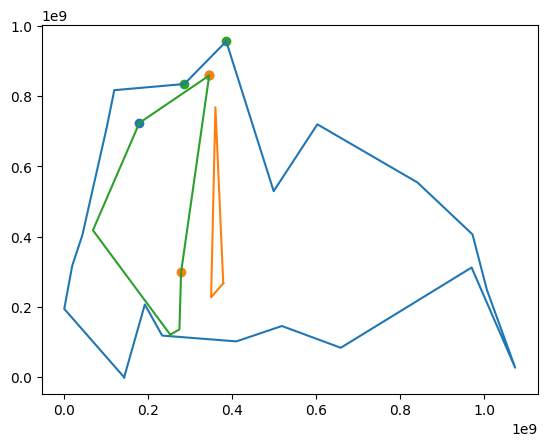

In [43]:
polygon_plt()

for e,_ in stat:
    print(intersection_point(Edge(refl[1], e.pt2, None), e).coordinate)
    xs = [e.pt1.coordinate[0], e.pt2.coordinate[0]]
    ys = [e.pt1.coordinate[1], e.pt2.coordinate[1]]
    plt.scatter(xs,ys)

plt.show()

(518170442, 145990133)
---
(972122497, 406678785)
(841172557, 554365113)
(602711995, 719961446)
(498647195, 529671996)
(385673579, 956170210)
(345167289, 859001776)
---


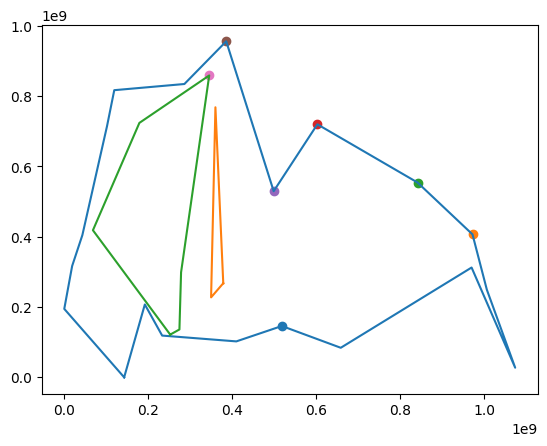

In [33]:
polygon_plt()

print(reflex.coordinate)
print("---")
for pt in FR:
    print(pt.coordinate)
print("---")

to_plot = [reflex, *FR]
# to_plot = [reflex, FR[0][0].pt1, FR[0][0].pt2]

for pt in to_plot:
    plt.scatter(pt.coordinate[0], pt.coordinate[1])

plt.show()

# Printing JSON

In [34]:
polygons_to_write = []
#for pp in poly.holes:
#    print(pp.points)
polygons_to_write = poly.holes #I hope you can make a list with all polygons and add those in the parameter "polygons_to_write"
#print(polygons_to_write)

#Name variables for dictionary
filename = path_to_testfile
print(filename)
leftbound = ''.join(filename).rindex('/')
rightbound = ''.join(filename).rindex('i')
#print(filename[leftbound+1:])
#print(filename[:rightbound])
print(filename[leftbound+1:rightbound-1])
instance = filename[leftbound+1:rightbound-1]
typename = "CGSHOP2023_Solution"

from decimal import Decimal

def to_float(d):
    d = Decimal(str(d)) #cast as string for proper fraction
    nom, den = d.as_integer_ratio()
    if den==1:
        print(d)
        return d
    else:
        print(nom, den)
        dict = {"num": nom, "den": den}
        return dict

lists = polygons_to_write
listsfin= []
listsdict = []

for item in lists:
    #print(item)
    for el in item.points:
        #print(el, el.coordinate, el.coordinate[0], el.coordinate[1])
        xc = el.coordinate[0]
        yc = el.coordinate[1]
        if(isinstance(xc, float)):
            xc = to_float(xc)
        if(isinstance(yc, float)):
            yc = to_float(yc)
        dictxy = {"x": xc, "y": yc}
        #print(dictxy)
        listsdict.append(dictxy)
    #print("NEW")
    listsfin.append(listsdict)
    #print(listsfin)
    listsdict = []

finaldict = {
    "type": typename,
    "instance": instance,
    "polygons": listsfin
}
#print(finaldict)
json_object = json.dumps(finaldict, indent=4)
with open("sol_"+instance+".json", "w") as outfile:
    outfile.write(json_object)

print("Created a json output file called:", "sol_"+instance+".json\n" , "for instance", instance,"\n", "with the following contents:\n", finaldict)
print("\nPlease use the polygons_to_write field to fill in all polygons that should be in the json file, this is now placeholded with the original holes")
        

./instances_v2/instances/fpg-poly_0000000020_h2.instance.json
fpg-poly_0000000020_h2
Created a json output file called: sol_fpg-poly_0000000020_h2.json
 for instance fpg-poly_0000000020_h2 
 with the following contents:
 {'type': 'CGSHOP2023_Solution', 'instance': 'fpg-poly_0000000020_h2', 'polygons': [[{'x': 349623949, 'y': 227499932}, {'x': 359939980, 'y': 768422084}, {'x': 378607327, 'y': 267682836}], [{'x': 68249156, 'y': 418481519}, {'x': 178867385, 'y': 723985109}, {'x': 345167289, 'y': 859001776}, {'x': 278159008, 'y': 298820764}, {'x': 274224193, 'y': 136143764}, {'x': 252289409, 'y': 121547145}]]}

Please use the polygons_to_write field to fill in all polygons that should be in the json file, this is now placeholded with the original holes
